#### Mask RNN 

### Input
- Image

### Target
- Boxes of objects
- Labels
- Mask data  

path /home/forev/project/eglinton_images_for_sam2/Front/1/1_front_79.jpg w 400 h 240 channels 3
(240, 400, 3)
(360, 640, 3)
path output/79.png w 400 h 240 channels 1
{'1': 1, '2': 10, '3': 10, '4': 4, '5': 13, '6': 6}
[0 1 2 3 4 5 6]
2057


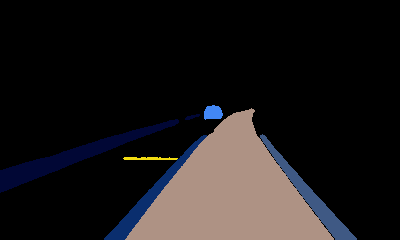

In [1]:
from PIL import Image
import yaml
import os
import numpy as np
from label_manager import LabelManager
import label_manager
import torch
import cv2
import pandas as pd
import json

obj_entity_list = []
obj_entity_list.append({'Entity': 'Background', 'ID': 0, 'Colour': [0,0,0]})

input_df = pd.read_csv('input.csv')
target_df = pd.read_csv('target.csv')

idx = 80

row_data = input_df.iloc[idx].to_dict()
path = row_data['path']
w = int(row_data['width'])
h = int(row_data['height'])
channels = int(row_data['channels'])
print('path', path, 'w', w, 'h', h, 'channels', channels)
pixels_str = row_data['pixels']
pixel_values = np.array(list(map(int, pixels_str.split(','))))
if channels == 1:
    mode = 'L'  # Grayscale
    expected_shape = (h, w)
elif channels == 3:
    mode = 'RGB'
    expected_shape = (h, w, 3)

img_array = pixel_values.reshape(expected_shape).astype(np.uint8)
in_img = Image.fromarray(img_array, mode=mode)
img = Image.open('rev_input/100.jpg')
img = np.array(img)
print(img_array.shape)
print(img.shape)

#Target
row_data = target_df.iloc[idx].to_dict()
path = row_data['path']
w = int(row_data['width'])
h = int(row_data['height'])
channels = int(row_data['channels'])
print('path', path, 'w', w, 'h', h, 'channels', channels)
pixels_str = row_data['pixels']
pixel_values = np.array(list(map(int, pixels_str.split(','))))
if channels == 1:
    mode = 'L'  # Grayscale
    expected_shape = (h, w)
elif channels == 3:
    mode = 'RGB'
    expected_shape = (h, w, 3)
elif channels == 4:
    mode = 'RGBA'
    expected_shape = (h, w, 4)
img_array = pixel_values.reshape(expected_shape).astype(np.uint8)
mask_img = Image.fromarray(img_array, mode=mode)

mask = np.array(mask_img)
obj_ids = np.unique(mask)

label_map = row_data['object_label_map']
target_label = json.loads(label_map)

with open("object.yaml", 'r') as file:
    config = yaml.safe_load(file)
    for ele in config['DRIVING_objects']:
        entity_map = {}
        entity_map['Entity'] = ele['Entity']
        entity_map['ID'] = ele['ID']
        entity_map['Colour'] = ele['Colour']
        obj_entity_list.append(entity_map)


colour_list = []
for i, entity in enumerate(obj_entity_list):
    cur_colour = entity['Colour']
    colour_list+=cur_colour
    if (i >= len(obj_ids) + 1):
        break

print(target_label)
print(obj_ids)
print(len(input_df))

mask_img.putpalette(colour_list)
mask_img


### Prepare the target data

boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.

labels (Int64Tensor[N]): the class label for each ground-truth box

masks (UInt8Tensor[N, H, W]): the segmentation binary masks for each instance

[0 1 2 3 4 5 6]
masks (6, 240, 400)


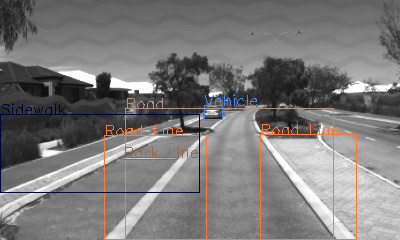

In [7]:
label_mgr = LabelManager()
# idx = 80
# in_img = Image.open('rev_input/{}.jpg'.format(idx))
# mask_img = Image.open('rev_mask/{}.png'.format(idx))
# mask = np.array(mask_img)

# # labels = label_manager.parse_label('rev_mask/{}.yaml'.format(idx))
# with open('rev_mask/{}.yaml'.format(idx), 'r') as file:
#         target_label = yaml.safe_load(file)



obj_ids = np.unique(mask)
# first id is the background, so remove it
print(obj_ids)
obj_ids = obj_ids[1:]
masks = mask == obj_ids[:, None, None]
print('masks', masks.shape)
num_objs = len(obj_ids)
img_array = np.array(in_img)

labels =[]
for i in obj_ids:
    #print(target_label)
    label = target_label[str(i)]
    labels.append(label)

boxes = []
out_img = np.zeros((in_img.height, in_img.width, 4), np.uint8)
for i in range(num_objs):
    pos = np.where(masks[i])
    if pos[0].size == 0 or pos[1].size == 0:
        raise AttributeError
        continue
    xmin_val = np.min(pos[1])
    xmax_val = np.max(pos[1])
    ymin_val = np.min(pos[0])
    ymax_val = np.max(pos[0])

    if xmin_val >= xmax_val:
        if xmax_val < masks.shape[2] - 1: # If there's space to expand to the right
            xmax_val = xmin_val + 1
        elif xmin_val > 0: # If at the right edge, expand to the left
            xmin_val = xmax_val - 1
        else: 
            xmax_val = xmin_val + 0.1 # Ensure float and slightly larger

    # Ensure ymax is strictly greater than ymin
    if ymin_val >= ymax_val:
        if ymax_val < masks.shape[1] - 1: # If there's space to expand down
            ymax_val = ymin_val + 1
        elif ymin_val > 0: # If at the bottom edge, expand up
            ymin_val = ymax_val - 1
        else: # Similar to width, for 1-pixel height
            ymax_val = ymin_val + 0.1

    # Convert to float, as downstream transforms and model expect float boxes
    current_box = [float(xmin_val), float(ymin_val), float(xmax_val), float(ymax_val)]

    # Final check, this should ideally not be needed if above logic is perfect for all edge cases
    if not (current_box[2] > current_box[0] and current_box[3] > current_box[1]):
        if not (current_box[2] > current_box[0]):
            current_box[2] = current_box[0] + 0.1
        if not (current_box[3] > current_box[1]):
            current_box[3] = current_box[1] + 0.1
     
    boxes.append(current_box)
    #boxes.append([xmin, ymin, xmax, ymax])
    pt1 = tuple([int(current_box[0]), int(current_box[1])])
    pt2 = tuple([int(current_box[2]), int(current_box[3])])
    # print(pt1)
    # print(pt2)
    
    label = labels[i]
    colour = label_mgr.get_colour(label)
    name = label_mgr.get_names()[label - 1]
    #print('label: ', label, 'name:', name)

    cv2.rectangle(img_array, pt1, pt2,color=colour, thickness=1)
    cv2.putText(img_array,name, pt1, cv2.FONT_HERSHEY_SIMPLEX, 0.5, colour,thickness=1)


updated_img = Image.fromarray(img_array)
updated_img

In [8]:
print(input_df.shape, input_df.columns)
print(target_df.shape, target_df.columns)


test_df = target_df.sample(n=200)

label_count = {}

for idx in range(len(test_df)): 
    row_data = test_df.iloc[idx].to_dict()
    path = row_data['path']
    w = int(row_data['width'])
    h = int(row_data['height'])
    channels = int(row_data['channels'])
    #print('path', path, 'w', w, 'h', h, 'channels', channels)
    pixels_str = row_data['pixels']
    pixel_values = np.array(list(map(int, pixels_str.split(','))))
    if channels == 1:
        mode = 'L'  # Grayscale
        expected_shape = (h, w)
    elif channels == 3:
        mode = 'RGB'
        expected_shape = (h, w, 3)
    elif channels == 4:
        mode = 'RGBA'
        expected_shape = (h, w, 4)
    img_array = pixel_values.reshape(expected_shape).astype(np.uint8)
    mask_img = Image.fromarray(img_array, mode=mode)
    label_map = row_data['object_label_map']
    target_label = json.loads(label_map)

    mask = np.array(mask_img)
    obj_ids = np.unique(mask)

    obj_ids = obj_ids[1:]
    masks = mask == obj_ids[:, None, None]

    num_objs = len(obj_ids)

    for i in obj_ids:
        #print(target_label)
        label = target_label[str(i)]
        name = label_mgr.get_names()[label - 1]
        if (name in label_count):
            label_count[name] += 1
        else:
            label_count[name] = 1

label2_count = {}
for idx in range(len(target_df)): 
    row_data = target_df.iloc[idx].to_dict()
    path = row_data['path']
    w = int(row_data['width'])
    h = int(row_data['height'])
    channels = int(row_data['channels'])
    #print('path', path, 'w', w, 'h', h, 'channels', channels)
    pixels_str = row_data['pixels']
    pixel_values = np.array(list(map(int, pixels_str.split(','))))
    if channels == 1:
        mode = 'L'  # Grayscale
        expected_shape = (h, w)
    elif channels == 3:
        mode = 'RGB'
        expected_shape = (h, w, 3)
    elif channels == 4:
        mode = 'RGBA'
        expected_shape = (h, w, 4)
    img_array = pixel_values.reshape(expected_shape).astype(np.uint8)
    mask_img = Image.fromarray(img_array, mode=mode)
    label_map = row_data['object_label_map']
    target_label = json.loads(label_map)

    mask = np.array(mask_img)
    obj_ids = np.unique(mask)

    obj_ids = obj_ids[1:]
    masks = mask == obj_ids[:, None, None]

    num_objs = len(obj_ids)

    for i in obj_ids:
        #print(target_label)
        label = target_label[str(i)]
        name = label_mgr.get_names()[label - 1]
        if (name in label2_count):
            label2_count[name] += 1
        else:
            label2_count[name] = 1

print(label_count)
print(label2_count)


(2057, 5) Index(['path', 'width', 'height', 'channels', 'pixels'], dtype='object')
(2057, 6) Index(['path', 'width', 'height', 'channels', 'object_label_map', 'pixels'], dtype='object')
{'Vehicle': 295, 'Road_Line': 401, 'Road': 201, 'Sidewalk': 189, 'Motorcycle': 9, 'Park_Line': 44, 'Giveaway_Sign': 2}
{'Vehicle': 2967, 'Road_Line': 4107, 'Road': 2073, 'Park_Line': 443, 'Sidewalk': 1950, 'Motorcycle': 63, 'Giveaway_Sign': 42}


### Define training process

In the training function, create a dictionary to store losses for each training iteration. 

In [9]:
import utils
from model import get_transform, build_model
import math
import sys
from tqdm import tqdm

def train_one_epoch_v2(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    # Build a dictionary to recored losses
    LOSS = {
        'loss_classifier':[],
        'loss_box_reg':[],
        'loss_mask':[],
        'loss_objectness':[],
        'loss_rpn_box_reg':[],
        'loss_sum':[]
    }

    lr_scheduler = None
    # Warm up the model in the first epoch
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    # Training process
    for images, targets in tqdm(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        # try:
        #     loss_dict = model(images, targets)
        # except AssertionError as e:
        #     print('SHWAN - error', targets)
        #     for key, value in targets.items():
        #         if isinstance(value, torch.Tensor):
        #             print(f"  {key}: shape={value.shape}, dtype={value.dtype}, min={value.min()}, max={value.max()}")
        #         else:
        #             print(f"  {key}: {type(value)}, {value}")
        #     print(e)  # Print the AssertionError message itself
        #     return
        for i in loss_dict.keys():
            LOSS[i].append(loss_dict[i].item())    
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        LOSS['loss_sum'].append(loss_value)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

    return LOSS

### Define Validating process



In [10]:
from tqdm import tqdm
def val_one_epoch(model, data_loader, device, epoch):
    # Build a dictionary to recored losses
    LOSS = {
        'val_loss_classifier':[],
        'val_loss_box_reg':[],
        'val_loss_mask':[],
        'val_loss_objectness':[],
        'val_loss_rpn_box_reg':[],
        'val_loss_sum':[]
    }
    
    # Speed up evaluation by not computing gradients
    with torch.no_grad():
        model.train()
        
        # Evaluating process
        for images, targets in tqdm(data_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            # try:
            #     loss_dict = model(images, targets)
            # except AssertionError:
            #     print('SHWAN - error2', targets)
            #     continue
            for i in loss_dict.keys():
                LOSS["val_"+i].append(loss_dict[i].item())    
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            LOSS['val_loss_sum'].append(loss_value)

    return LOSS

In [11]:

class RevDatasetV2(torch.utils.data.Dataset):
    def __init__(self, root, transforms, input_df = None, target_df = None):
        self.root = root
        self.transforms = transforms

        if input_df is not None:
            self.input_df = input_df
        else:
            self.input_df = pd.read_csv('input.csv')
        if target_df is not None:
            self.target_df = target_df
        else:
            self.target_df = pd.read_csv('target.csv')


        self.log = False
        self.label_manager = LabelManager()

    def __getitem__(self, idx):

        row_data = self.input_df.iloc[idx].to_dict()
        path = row_data['path']
        w = int(row_data['width'])
        h = int(row_data['height'])
        channels = int(row_data['channels'])
        #print('path', path, 'w', w, 'h', h, 'channels', channels)
        pixels_str = row_data['pixels']
        pixel_values = np.array(list(map(int, pixels_str.split(','))))
        if channels == 1:
            mode = 'L'  # Grayscale
            expected_shape = (h, w)
        elif channels == 3:
            mode = 'RGB'
            expected_shape = (h, w, 3)

        img_array = pixel_values.reshape(expected_shape).astype(np.uint8)
        img = Image.fromarray(img_array, mode=mode)

        #Target
        row_data = self.target_df.iloc[idx].to_dict()
        path = row_data['path']
        w = int(row_data['width'])
        h = int(row_data['height'])
        channels = int(row_data['channels'])
        #print('path', path, 'w', w, 'h', h, 'channels', channels)
        pixels_str = row_data['pixels']
        pixel_values = np.array(list(map(int, pixels_str.split(','))))
        if channels == 1:
            mode = 'L'  # Grayscale
            expected_shape = (h, w)
        elif channels == 3:
            mode = 'RGB'
            expected_shape = (h, w, 3)
        elif channels == 4:
            mode = 'RGBA'
            expected_shape = (h, w, 4)
        img_array = pixel_values.reshape(expected_shape).astype(np.uint8)
        mask_img = Image.fromarray(img_array, mode=mode)

        label_map = row_data['object_label_map']
        target_label = json.loads(label_map)

        # convert the PIL Image into a numpy array
        mask = np.array(mask_img)

        if (self.log) :
            print('mask shape', mask.shape)

        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]


        masks = mask == obj_ids[:, None, None]
        if (self.log) :
            print('masks shape', mask.shape)

        # get bounding box coordinates for each mask
        #print('idx', idx)
        num_objs = len(obj_ids)
        if (self.log) :
            print('num_objs: ', num_objs, 'obj_ids', obj_ids)

        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            if pos[0].size == 0 or pos[1].size == 0:
                raise AttributeError
                continue
            xmin_val = np.min(pos[1])
            xmax_val = np.max(pos[1])
            ymin_val = np.min(pos[0])
            ymax_val = np.max(pos[0])

            if xmin_val >= xmax_val:
                # If xmin and xmax are the same (e.g., single pixel width)
                # Make the box 1 pixel wide.
                # Ensure xmax_val does not exceed image width boundary (mask_width - 1 for index)
                # masks.shape[2] is the width of the mask
                if xmax_val < masks.shape[2] - 1: # If there's space to expand to the right
                    xmax_val = xmin_val + 1
                elif xmin_val > 0: # If at the right edge, expand to the left
                    xmin_val = xmax_val - 1
                else: # Object is 1xH at column 0 in a 1-column wide image/mask part.
                    # This case is tricky. For now, if width is 1 pixel, make xmax = xmin + 0.1 (float)
                    # to pass the strict inequality for floats. The model should handle small float differences.
                    # Or, if your image width is guaranteed > 0, you can try to make xmax = 1 if xmin = 0.
                    # A more general approach to ensure x1 < x2:
                    xmax_val = xmin_val + 0.1 # Ensure float and slightly larger

            # Ensure ymax is strictly greater than ymin
            if ymin_val >= ymax_val:
                if ymax_val < masks.shape[1] - 1: # If there's space to expand down
                    ymax_val = ymin_val + 1
                elif ymin_val > 0: # If at the bottom edge, expand up
                    ymin_val = ymax_val - 1
                else: # Similar to width, for 1-pixel height
                    ymax_val = ymin_val + 0.1

            # Convert to float, as downstream transforms and model expect float boxes
            current_box = [float(xmin_val), float(ymin_val), float(xmax_val), float(ymax_val)]

            # Final check, this should ideally not be needed if above logic is perfect for all edge cases
            if not (current_box[2] > current_box[0] and current_box[3] > current_box[1]):
                # Fallback if still degenerate: make it a 0.1 unit width/height box
                # This is a patch; ideally, the logic above should handle all cases.
                # This could happen if img_w_from_mask or img_h_from_mask was 0 or 1.
                if not (current_box[2] > current_box[0]):
                    current_box[2] = current_box[0] + 0.1
                if not (current_box[3] > current_box[1]):
                    current_box[3] = current_box[1] + 0.1
                if (self.log):
                    print(f"Warning: Adjusted a degenerate box for image_id {idx}, obj_id {obj_ids[i]}: to {current_box}")


            boxes.append(current_box)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        # labels = torch.ones((num_objs,), dtype=torch.int64)
        #target_label = parse_label(label_path)
        
        labels =[]
        for i in obj_ids:
            if (self.log):
                print('obj', obj_ids, 'target', target_label)
            label = target_label[str(i)]
            labels.append(label)


        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if (self.log) :
            print('boxes:', boxes.shape, 'labels:', labels.shape, 'masks:', masks.shape, 'image_id:', image_id.shape, 'area:', area.shape, 'iscrowd:', iscrowd.shape, 'num_objs', num_objs)
            # print('boxes:', boxes.shape)
            # print('labels:', labels.shape)
            # print('masks:', masks.shape)
            # print('image_id:', image_id.shape)
            # print('area:', area.shape)
            # print('iscrowd:', iscrowd.shape)
            self.log = False

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.input_df)
    

### Start Training

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.mask_rcnn import MaskRCNN_ResNet50_FPN_V2_Weights
import transforms as T
def build_model(num_classes):
    print('build_model - num_classes: ', num_classes)
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from engine import train_one_epoch, evaluate
from rev_dataset import RevDataset
import utils
from label_manager import LabelManager

# load a pre-trained model for classification and return
# only the features
print('sh - 0')
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280
print('sh - 1')
label_manager = LabelManager()
# add background
label_num = label_manager.get_num() + 1
print('sh - 2')

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
print('sh - 3')

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)
print('sh - 5')

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=label_num,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

print('sh - 6')

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('sh - 7')

# our dataset has two classes only - background and person
num_classes = label_num
# use our dataset and defined transformations
dataset = RevDatasetV2('REV', get_transform(train=True), input_df, target_df)
print('sh - 7-1')
dataset_test = RevDatasetV2('REV', get_transform(train=False), input_df, target_df)
print('sh - 7-2')
print('hg - 0')

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-200])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-200:])

print('hg - 1')
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

print('hg - 2')
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

print('hg - 3')
# get the model using our helper function
model = build_model(num_classes)

# move model to the right device
model.to(device)
print('hg - 4')
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

print('hg - 5')
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

print('hg - 6')

# let's train it for 5 epochs
num_epochs = 10

train_losses = []
test_losses = []
eval_results = [] 


for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    print('start training 0')
    loss = train_one_epoch_v2(model, optimizer, data_loader, device, epoch, print_freq=10)
    train_losses.append(loss)
    # update the learning rate
    print('start training 1')
    lr_scheduler.step()
    # evaluate on the test dataset
    ret = evaluate(model, data_loader_test, device=device)
    eval_results.append(ret)

    loss = val_one_epoch(model, data_loader_test, device, epoch)
    test_losses.append(loss)
    print('')

print("That's it!")

torch.save(model.state_dict(), 'mask-rcnn.pt')

sh - 0
sh - 1
sh - 2
sh - 3
sh - 5


/home/forev/anaconda3/envs/shawn_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/forev/anaconda3/envs/shawn_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


sh - 6
sh - 7
sh - 7-1
sh - 7-2
hg - 0
hg - 1
hg - 2
hg - 3
build_model - num_classes:  29
hg - 4
hg - 5
hg - 6
start training 0


 10%|█         | 97/929 [00:29<04:11,  3.31it/s]


KeyboardInterrupt: 

### Plot Losses

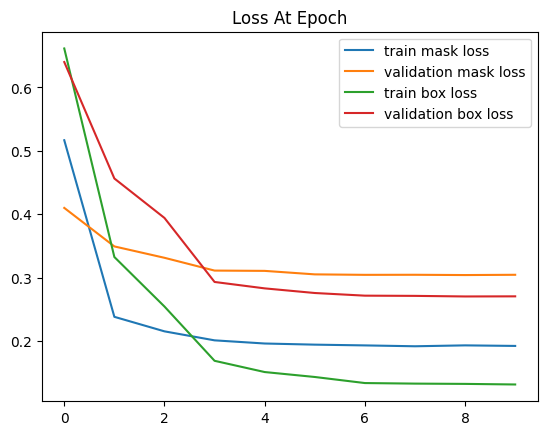

In [ ]:
from PIL import Image
from matplotlib import pyplot as plt

loss_mask = []
loss_mask_val = []
box_mask = []
box_mask_val = []

for l in train_losses:
    c_loss = l['loss_mask']
    #print(sum(c_loss))
    loss_mask.append(sum(c_loss) / 350)
    c_loss = l['loss_box_reg']
    #print(sum(c_loss))
    box_mask.append(sum(c_loss) / 350)

for l in test_losses:
    c_loss = l['val_loss_mask']
    loss_mask_val.append(sum(c_loss) / 50)
    c_loss = l['val_loss_box_reg']
    #print(sum(c_loss))
    box_mask_val.append(sum(c_loss) / 50)

plt.plot(loss_mask, label = 'train mask loss')
plt.plot(loss_mask_val, label = 'validation mask loss')
plt.plot(box_mask, label = 'train box loss')
plt.plot(box_mask_val, label = 'validation box loss')
plt.title('Loss At Epoch')


plt.legend()
#print(train_losses[3]['loss_box_reg'])




### Plot Evaluation Matrix

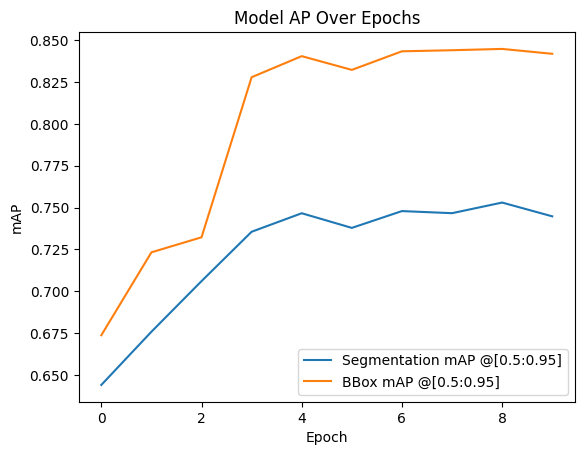

In [ ]:
# eval_results[-1].coco_eval['bbox'].summarize()
# eval_results[-1].coco_eval['segm'].summarize()

epoch_ap_scores = []
epoch_box_scores = []

for eval in eval_results:
    ap_score = eval.coco_eval['segm'].stats[0]
    box_score = eval.coco_eval['bbox'].stats[0]
    epoch_ap_scores.append(ap_score)
    epoch_box_scores.append(box_score)
    
plt.plot(epoch_ap_scores, label='Segmentation mAP @[0.5:0.95]')
plt.plot(epoch_box_scores, label='BBox mAP @[0.5:0.95]')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Model AP Over Epochs')
plt.legend()
plt.show()

In [ ]:
### Plot Evaluation Matrix

{(437, 1): array([[0.85544011, 0.        ],
       [0.        , 0.8312029 ],
       [0.        , 0.40970721]]), (437, 4): array([[0.97949626]]), (437, 6): array([[0.9472306]]), (437, 7): [], (437, 10): array([[0.        , 0.97491796],
       [0.97733168, 0.        ]]), (437, 13): [], (437, 16): []}


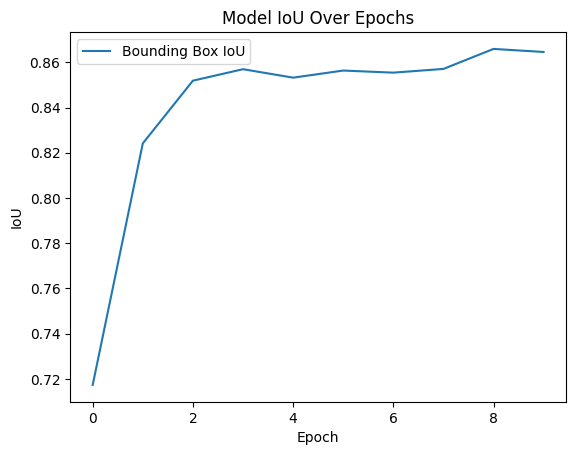

In [ ]:
ious = eval_results[6].coco_eval['bbox'].ious
print(ious)

bbox_iou = []

for eval in eval_results:
    ious = eval.coco_eval['bbox'].ious
    bbox_iou.append(ious[(437, 1)][0][0])

plt.plot(bbox_iou, label='Bounding Box IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Model IoU Over Epochs')
plt.legend()
plt.show()
